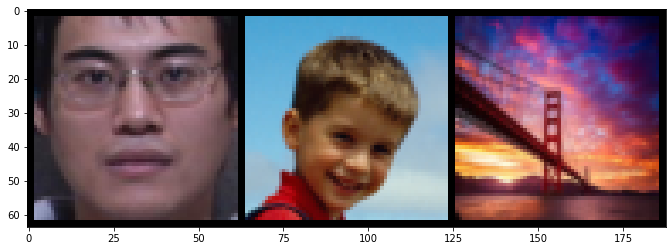

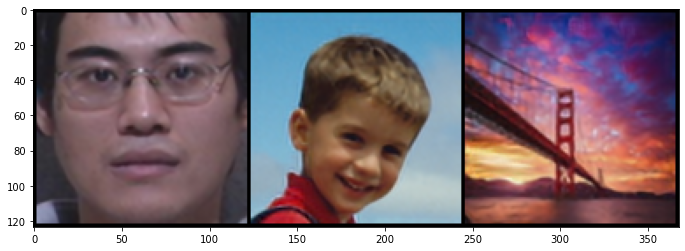

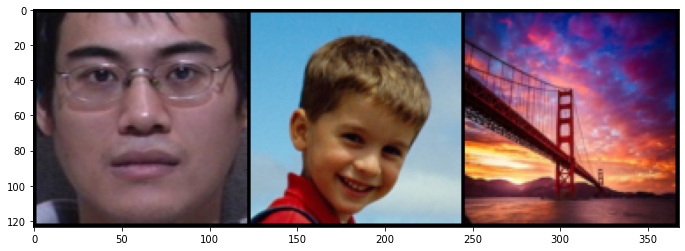

In [1]:
from __future__ import print_function, division

import time
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Path to the serealized trained model
model_path = './SuperResolution.pt' 

# Path to a directory of images for the demo
demodir = './images/'

# The low res versions of images will be resized to image_size x image_size
image_size = 60

# The factor by which the image size should increase after Super Resolution:
scaleup = 2

def is_image(filename, min_dim):    
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])

# Display the torch tensor as image with figsize = size
def show(torch_tensor, size=(4,4)):
    npimg = torch_tensor.numpy()
    plt.figure(figsize = size)
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

'''
    Custom PyTorch dataset class that inherits torch.utils.data.Dataset 
    Each instance of the ResolutionDataset is a pair of images:
    - an image of size lowres x lowres
    - the same image but of size lowres*upscale x lowres*upscale
''' 


class ResolutionDataset(Dataset):

    def __init__(self, root_dir, lowres = image_size, upscale = scaleup):
 
        
        list_files = list()        
        for (dirpath, dirnames, filenames) in os.walk(root_dir):
            list_files += [os.path.join(dirpath, file) for file in filenames if is_image(os.path.join(dirpath, file), upscale*lowres)]
        self.image_files = np.asarray(list_files)
    
        self.lowres = lowres
        self.upscale = upscale


    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image = Image.open(self.image_files[idx])   
        
        transform_LR = transforms.Compose([transforms.CenterCrop(min(image.size)), 
                                           transforms.Resize(self.lowres), transforms.ToTensor()])
        image_LR = transform_LR(image)
        
        transform_HR = transforms.Compose([transforms.CenterCrop(min(image.size)), 
                                           transforms.Resize(self.lowres*self.upscale), transforms.ToTensor()])
        image_HR = transform_HR(image)
        
        return image_LR, image_HR
    
'''
    The Super Resolution model from the Sub-Pixel Convolutional Neural Network paper
    (https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Shi_Real-Time_Single_Image_CVPR_2016_paper.pdf)
    upscale_factor = factor by which the image size should increase after Super Resolution
'''

class SubPixelNetwork(nn.Module):
    def __init__(self, upscale_factor):
        super(SubPixelNetwork, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(3, 64, (5, 5), (1, 1), (2, 2))
        self.conv2 = nn.Conv2d(64, 64, (3, 3), (1, 1), (1, 1))
        self.conv3 = nn.Conv2d(64, 32, (3, 3), (1, 1), (1, 1))
        self.conv4 = nn.Conv2d(32, (upscale_factor ** 2)*3, (3, 3), (1, 1), (1, 1))
        # Sub-pixel convolution: rearranges elements in a Tensor of shape (*, r^2C, H, W)
        # to a tensor of shape (C, rH, rW)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.pixel_shuffle(self.conv4(x))
        return x

    def _initialize_weights(self):
        nn.init.orthogonal_(self.conv1.weight, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.conv2.weight, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.conv3.weight, nn.init.calculate_gain('relu'))
        nn.init.orthogonal_(self.conv4.weight)   
    
def super_resolve(model, testloader, device):

    for i, data in enumerate(testloader):
        
        inputs = data[0].type('torch.FloatTensor').to(device)
        targets = data[1].type('torch.FloatTensor').to(device)
        
        with torch.no_grad():        
            outputs = model(inputs)

        if i==0:
            # Display the inputs, outputs and targets from the last batch:
            b_size = inputs.size()[0]
            inputs = torchvision.utils.make_grid(inputs, nrow=b_size, normalize=True)
            outputs = torchvision.utils.make_grid(outputs, nrow=b_size, normalize=True)
            targets = torchvision.utils.make_grid(targets, nrow=b_size, normalize=True)

            show(inputs.cpu(), size=(30,4))
            show(outputs.cpu(), size=(30,4))
            show(targets.cpu(), size=(30,4))
        
demoset = ResolutionDataset(demodir)    
dataloader = DataLoader(demoset, batch_size=3, shuffle=False) 

saved_model = SubPixelNetwork(scaleup).to(device)

checkpoint = torch.load(model_path)
saved_model.load_state_dict(checkpoint['state_dict'])
saved_model.eval()

super_resolve(saved_model, dataloader, device)
